In [1]:
import geopandas as gpd

In [59]:
gdf=gpd.read_file("activities_geo.json")
gdf.set_index("id", inplace=True)
gdf.geometry[gdf.geometry.notnull()] = gdf[gdf.geometry.notnull()].geometry.apply(lambda x: x.simplify(0.001, preserve_topology=False))
gdf.to_file("activities_geo_compr.json", driver="GeoJSON")
tempdic=gdf[gdf.index=="9058273521"].to_dict(orient="index")["9058273521"]
tempdic["start_date_local"]=str(tempdic["start_date_local"])
tempdic["geometry"]=tempdic["geometry"].wkt

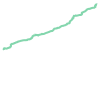

In [25]:
gdf.loclist(gdf[gdf.id=="9058273521"].geometry)[0].simplify(.001, preserve_topology=False)

In [37]:
from shapely import wkt
import pandas as pd
from firebase_admin import db, initialize_app, get_app
get_app()
ref = db.reference(url="https://stravamap-386413-default-rtdb.europe-west1.firebasedatabase.app")
df=pd.DataFrame.from_dict(ref.get(),orient="index")
df.loc[df.geometry.notnull(),"geometry"] = df[df.geometry.notnull()].geometry.apply(wkt.loads)
gdf = gpd.GeoDataFrame(df[df.geometry.notnull()], geometry="geometry")

In [65]:
refdic=ref.get()
for key,val in refdic.items():
    if "geometry" in val:
        print(f"Updating {key}")
        val["geometry"]=wkt.loads(val["geometry"])
        val["geometry"]=val["geometry"].simplify(0.001, preserve_topology=False)
        val["geometry"]=val["geometry"].wkt
        ref.child(key).set(val)

Updating 232418349
Updating 233135383
Updating 233135388
Updating 233136060
Updating 233136061
Updating 233429816
Updating 234186110
Updating 234513137
Updating 241659297
Updating 272741725
Updating 275706719
Updating 282229520
Updating 282229532
Updating 291148089
Updating 291148090
Updating 291148102
Updating 291148107
Updating 291148109
Updating 291148130
Updating 291148143
Updating 333648743
Updating 333648757
Updating 333648775
Updating 344015064
Updating 349762825
Updating 349762826
Updating 349762834
Updating 349762839
Updating 349762841
Updating 349762847
Updating 349762968
Updating 358009227
Updating 359547607
Updating 359547668
Updating 363473541
Updating 363473553
Updating 366102405
Updating 366104544
Updating 368030456
Updating 373430908
Updating 377306092
Updating 393532913
Updating 420785315
Updating 441641039
Updating 448958031
Updating 456704349
Updating 457424240
Updating 457971252
Updating 458752043
Updating 460001803
Updating 520725591
Updating 522873723
Updating 535

In [64]:
refdic["209180122"]

{'city': 'Cambridge',
 'country': 'United Kingdom',
 'distance': 5194.2,
 'elapsed_time': 3991,
 'name': '10/19/2014 Cambridge, United Kingdom',
 'sport_type': 'Workout',
 'start_date_local': '2014-10-19T12:01:13Z',
 'total_elevation_gain': 0.0,
 'type': 'Workout'}

In [61]:
ref.get()["9058273521"]

{'distance': 225729.0,
 'elapsed_time': 35715,
 'geometry': 'LINESTRING (8.555151 47.367888, 8.554968 47.370566, 8.548654 47.37704, 8.548219 47.383057, 8.548717 47.389128, 8.556228 47.402255, 8.561453 47.403972, 8.573116 47.404227, 8.597439 47.396302, 8.61539 47.396872, 8.618412 47.397356, 8.633577 47.406935, 8.650585 47.410956, 8.66956 47.419286, 8.677712 47.418384, 8.682448 47.41975, 8.691247 47.433901, 8.695365 47.436731, 8.701013 47.437492, 8.703889 47.440943, 8.703153 47.446838, 8.708026 47.460513, 8.704457 47.470127, 8.70432 47.482045, 8.718242 47.495695, 8.733133 47.498368, 8.733904 47.500251, 8.751644 47.500781, 8.759436 47.506187, 8.77087 47.50792, 8.780124 47.512608, 8.783326 47.518188, 8.805513 47.522424, 8.813084 47.525732, 8.817381 47.532293, 8.831024 47.535894, 8.851247 47.538261, 8.860589 47.545103, 8.862537 47.548396, 8.861704 47.550346, 8.865833 47.552627, 8.891972 47.555883, 8.919794 47.566227, 8.944593 47.570232, 8.94613 47.5717, 8.969981 47.577229, 8.990442 47.57989

In [55]:
gdf

,city,country,distance,elapsed_time,name,sport_type,start_date_local,total_elevation_gain,type,geometry
id,,,,,,,,,,
232418349,San Martino,Italy,11080.9,12670,"12/24/2014 Trentino-Alto Adige, Italy",Hike,2014-12-24 10:22:14+00:00,952.6,Hike,"LINESTRING (12.24944 46.83842, 12.25817 46.837..."
233135383,San Martino,Italy,7233.6,2561,"12/22/2014 Binter, Trentino-Alto Adige, Italy",Hike,2014-12-22 17:09:57+00:00,236.1,Hike,"LINESTRING (12.24838 46.83859, 12.24759 46.846..."
233135388,Außervillgraten,Austria,6195.3,11887,"12/23/2014 Außervillgraten, Tirol, Austria",Hike,2014-12-23 11:37:07+00:00,378.4,Hike,"LINESTRING (12.40573 46.77622, 12.38595 46.776..."
233136060,San Martino,Italy,13435.8,16715,"12/26/2014 Binter, Trentino-Alto Adige, Italy",Hike,2014-12-26 09:45:56+00:00,1324.4,Hike,"LINESTRING (12.24795 46.84374, 12.24347 46.843..."
233136061,San Martino,Italy,10048.4,18026,"12/25/2014 Binter, Trentino-Alto Adige, Italy",Hike,2014-12-25 08:46:33+00:00,1207.4,Hike,"LINESTRING (12.25449 46.84734, 12.25280 46.852..."
...,...,...,...,...,...,...,...,...,...,...
9011253437,Zürich,Switzerland,73080.8,13237,Afternoon Ride,Ride,2023-05-04 17:13:30+00:00,1782.0,Ride,"LINESTRING (8.55606 47.36596, 8.55372 47.36908..."
9023066266,Zürich (Kreis 8) / Mühlebach,Switzerland,88795.5,17608,Afternoon Ride,Ride,2023-05-06 15:26:04+00:00,1747.0,Ride,"LINESTRING (8.55975 47.36198, 8.56877 47.35997..."
9027929337,Niederurnen,Switzerland,19728.9,20919,Federispitz & Mattstock,Hike,2023-05-07 10:10:30+00:00,2239.0,Hike,"LINESTRING (9.05373 47.13989, 9.06720 47.14648..."
